In [1]:
import sys
sys.path.append('/home/flint/diplom/experiments')

In [2]:
import compiler_gym
import gym
import pandas as pd
import torch
from compiler_gym import CompilerEnv
from tabulate import tabulate
from tqdm import tqdm

from config.config import TrainConfig
from env.cfg_grind import compile_and_get_instructions
from runtime_eval.jotai.eval import measure_execution_mean_and_std
from utils import (
    get_agent,
    get_model_path,
    optimize_with_model,
)
from config.action_config import *

import matplotlib.pyplot as plt
import numpy as np

MODEL_ITERS = 10
RUNTIME_COUNT = 30
BIN_NAME = "tmp_o3_cbench_test_cfg_grind_bin"
RUN_TIME = "daily-capybara-88"

In [3]:
def get_speedup(compare_mean, model_mean) -> float:
    return compare_mean / max(model_mean, 1e-12)

In [4]:
env = gym.make("llvm-v0")
benchmarks = list(env.datasets["benchmark://cbench-v1"].benchmarks())

In [5]:
# config = TrainConfig()
# config.algorithm = "LstmDQN"
# config.fc_dim = 128
# config.lstm_hiddem_size = 256
# config.actions = COMPLETE_ACTION_SET
# config.observation_space = "InstCountNorm"
# config.observation_size = 69

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # agent = get_agent(
# #     config,
# #     device,
# #     policy_net_path="/home/flint/diplom/experiments/" + get_model_path(RUN_TIME),
# # )

In [6]:
math_benchs = {
    "qsort",
    "stringsearch",
    "susan",
    "tiff2bw",
    "tiff2rgba",
    "tiffdither",
    "tiffmedian",
}

In [7]:
results = {}

In [8]:
o2_seq = [f for f in O2_SEQ if f in env.action_space.flags]

In [9]:
for benchmark in benchmarks:
    benchmark_name = str(benchmark).split('/')[-1]
    print(benchmark_name)
    results[benchmark_name] = []
    with compiler_gym.make("llvm-v0", benchmark=benchmark) as new_env:
        new_env.reset()
        if not new_env.observation["IsRunnable"]:
            print(f"Benchmark {benchmark} not runnable, skip it")
            continue

        try:
            benchmark.validate(new_env)
        except Exception as e:
            benchmark_args = e.msg.split(".bc")[-1].strip()
            cg_working_dir = e.dir

        linkopts = (
            ["-lm"]
            if str(benchmark).rsplit("/", maxsplit=1)[-1] in math_benchs
            else []
        )

        new_env.reset()
        for i in tqdm(range(len(o2_seq) + 1)):
            instructions_number = compile_and_get_instructions(
                ir=new_env.observation["Ir"],
                sequence=o2_seq[:i],
                result_path=BIN_NAME,
                execution_args=benchmark_args,
                linkopts=linkopts,
            )
            results[benchmark_name].append(instructions_number)
        

adpcm
Benchmark benchmark://cbench-v1/adpcm not runnable, skip it
bitcount


100%|███████████████████████████████████████████| 94/94 [06:59<00:00,  4.47s/it]


blowfish


100%|███████████████████████████████████████████| 94/94 [01:26<00:00,  1.09it/s]


bzip2


100%|███████████████████████████████████████████| 94/94 [05:53<00:00,  3.76s/it]


crc32


100%|███████████████████████████████████████████| 94/94 [01:23<00:00,  1.12it/s]


dijkstra


100%|███████████████████████████████████████████| 94/94 [01:19<00:00,  1.18it/s]


ghostscript
Benchmark benchmark://cbench-v1/ghostscript not runnable, skip it
gsm


100%|███████████████████████████████████████████| 94/94 [02:40<00:00,  1.71s/it]


ispell
Benchmark benchmark://cbench-v1/ispell not runnable, skip it
jpeg-c


100%|███████████████████████████████████████████| 94/94 [06:21<00:00,  4.06s/it]


jpeg-d


100%|███████████████████████████████████████████| 94/94 [06:10<00:00,  3.94s/it]


lame
Benchmark benchmark://cbench-v1/lame not runnable, skip it
patricia


100%|███████████████████████████████████████████| 94/94 [01:30<00:00,  1.03it/s]


qsort


100%|███████████████████████████████████████████| 94/94 [03:10<00:00,  2.02s/it]


rijndael
Benchmark benchmark://cbench-v1/rijndael not runnable, skip it
sha


100%|███████████████████████████████████████████| 94/94 [01:23<00:00,  1.13it/s]


stringsearch


100%|███████████████████████████████████████████| 94/94 [01:32<00:00,  1.01it/s]


stringsearch2


100%|███████████████████████████████████████████| 94/94 [01:26<00:00,  1.08it/s]


susan


100%|███████████████████████████████████████████| 94/94 [02:28<00:00,  1.58s/it]


tiff2bw


100%|███████████████████████████████████████████| 94/94 [06:43<00:00,  4.29s/it]


tiff2rgba


100%|███████████████████████████████████████████| 94/94 [06:49<00:00,  4.36s/it]


tiffdither


100%|███████████████████████████████████████████| 94/94 [06:42<00:00,  4.28s/it]


tiffmedian


100%|███████████████████████████████████████████| 94/94 [07:02<00:00,  4.50s/it]


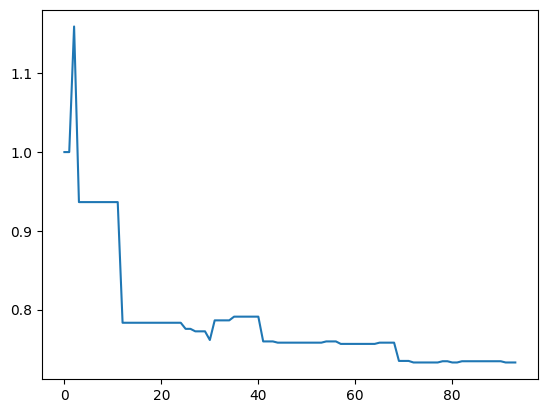

In [10]:
data = np.array(results['bitcount'])
plt.plot(data / data[0])
plt.show()

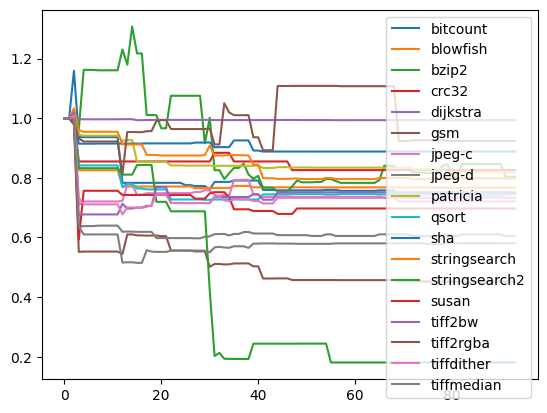

In [11]:
for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        plt.plot(np_data / np_data[0], label=name)

plt.legend() 
plt.show()

In [12]:
results = {name: data for name, data in results.items() if len(data) > 0}

In [13]:
df = pd.DataFrame(data=results)

In [14]:
df.to_csv("o2_no_analtical_llc_rewards.csv")

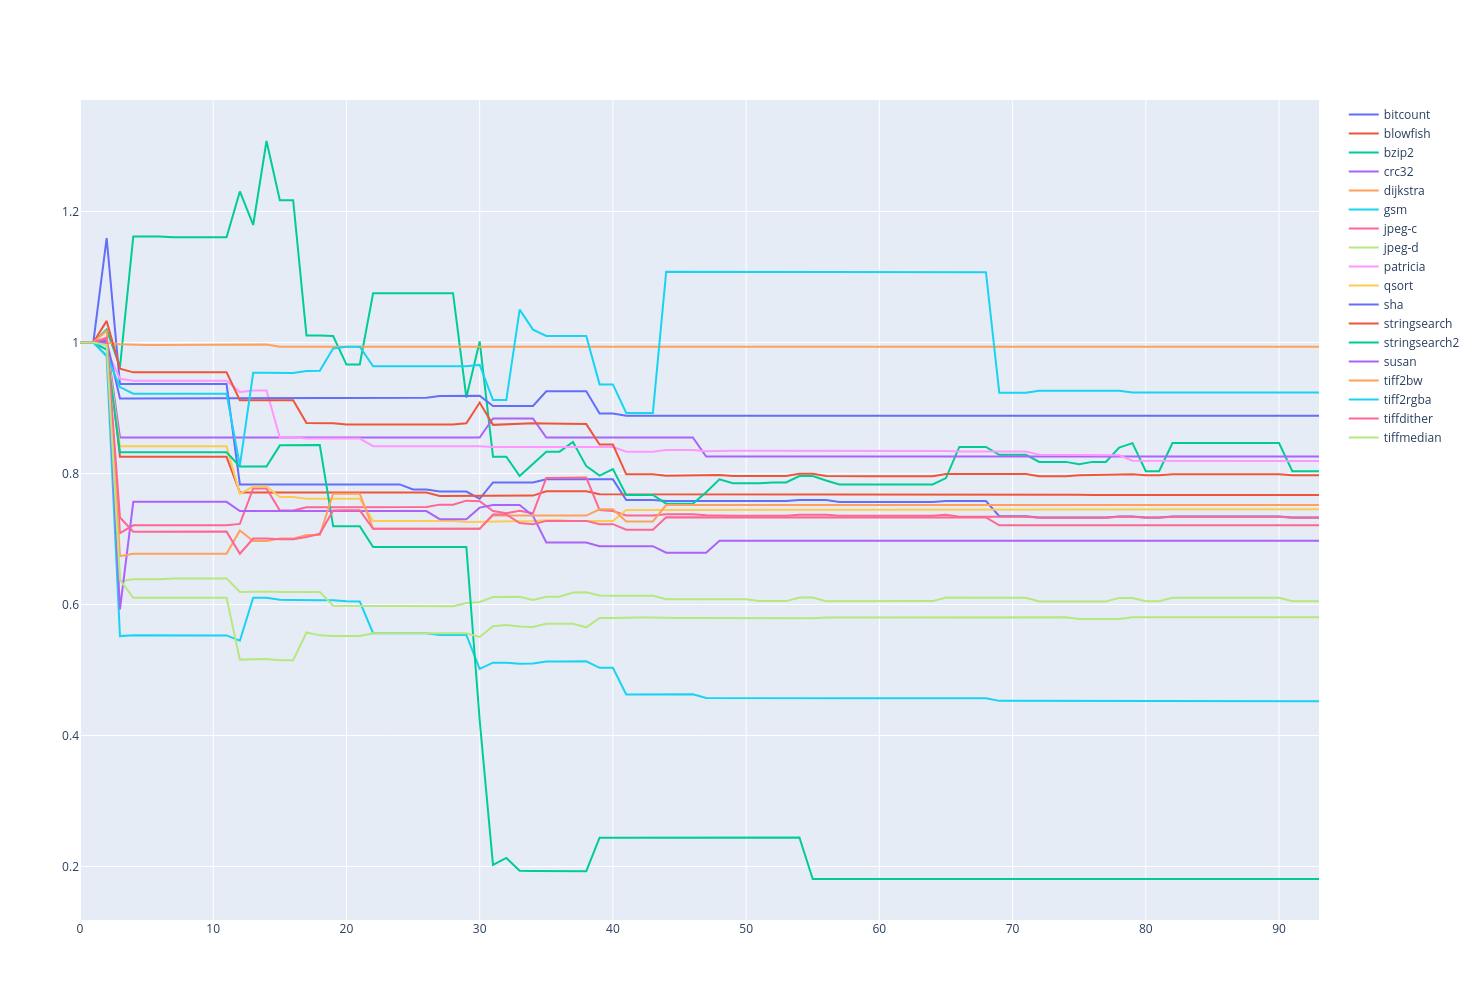

In [16]:
import plotly.graph_objects as go


fig = go.Figure()

for name, data in results.items():
    if len(data) > 0:
        np_data = np.array(data)
        fig.add_trace(go.Scatter(y=np_data / np_data[0],
                    mode='lines',
                    # mode='lines+markers',
                    name=name))
fig.update_layout(
    width=1750, height=1000
    # width=500, height=1500
)
fig.show()

In [19]:
agmins_prev = list(sorted(set(agmins)))
agmins_prev

[3, 12, 16, 28, 29, 30, 43, 46, 55, 59, 74, 93]

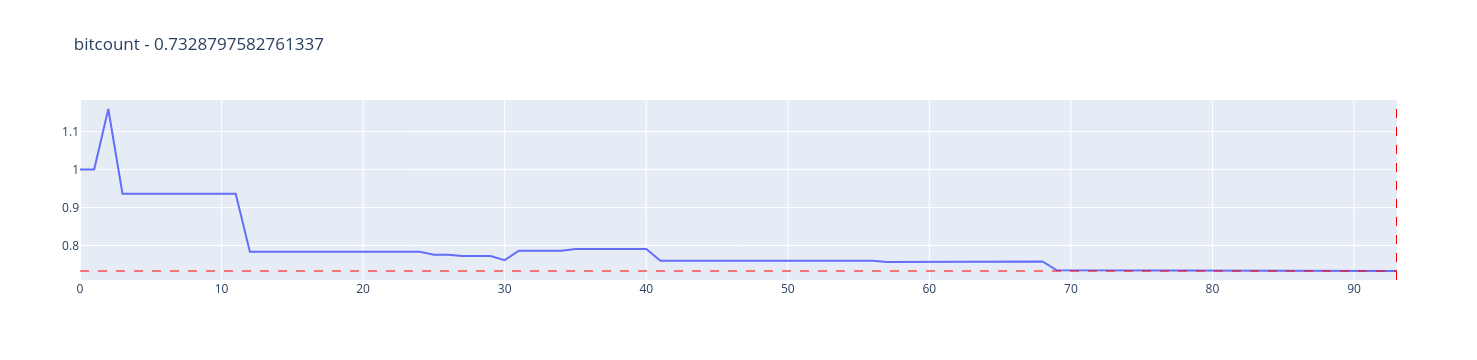

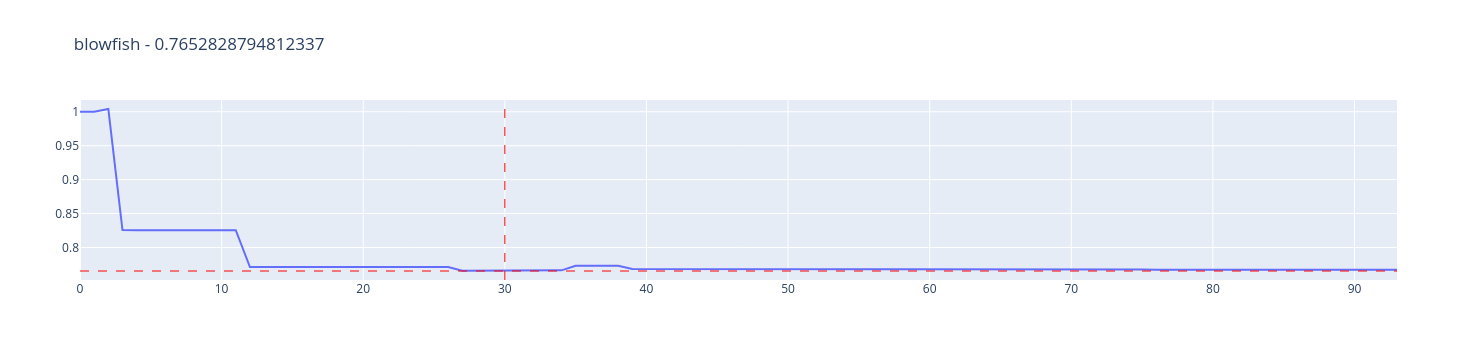

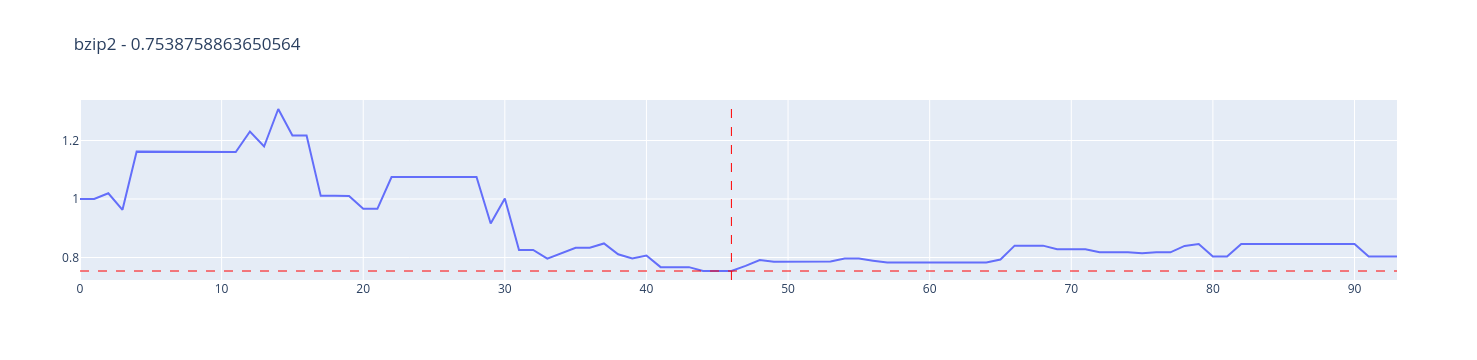

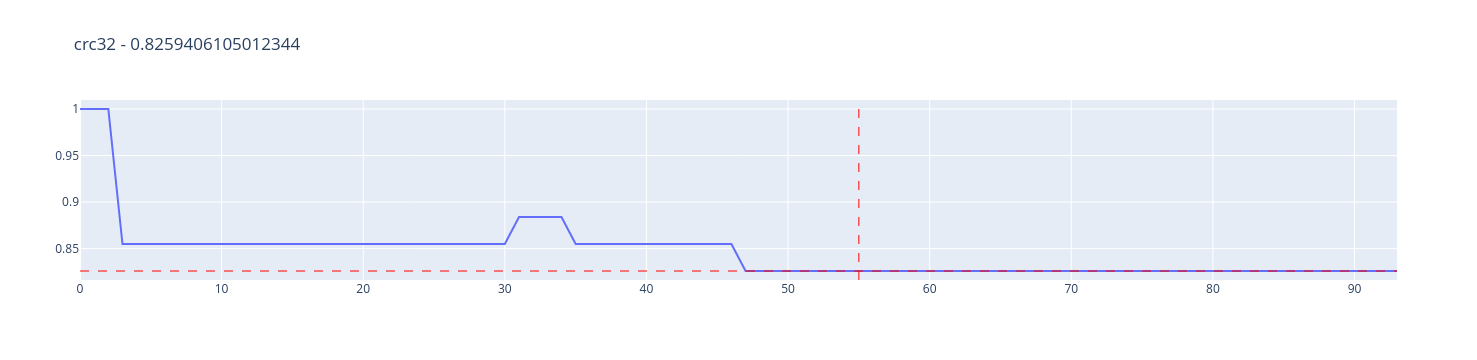

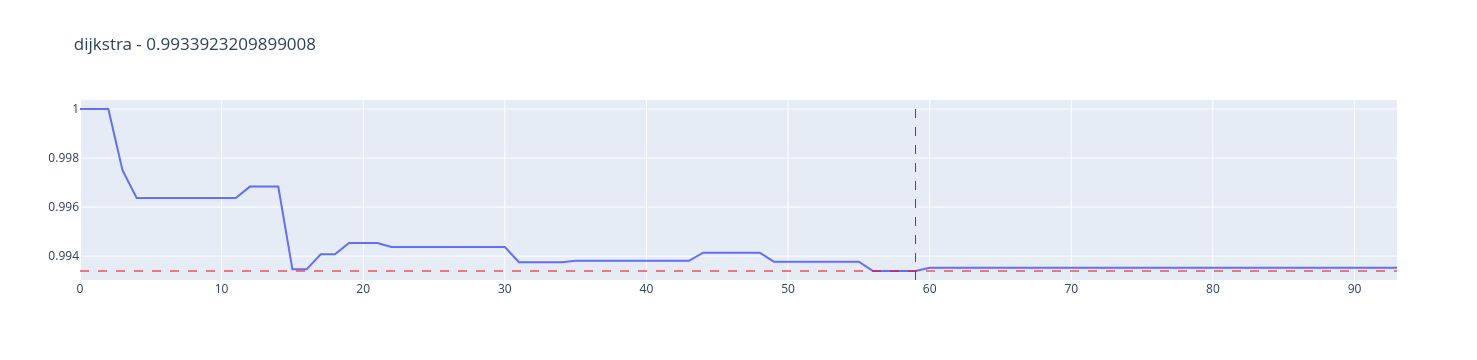

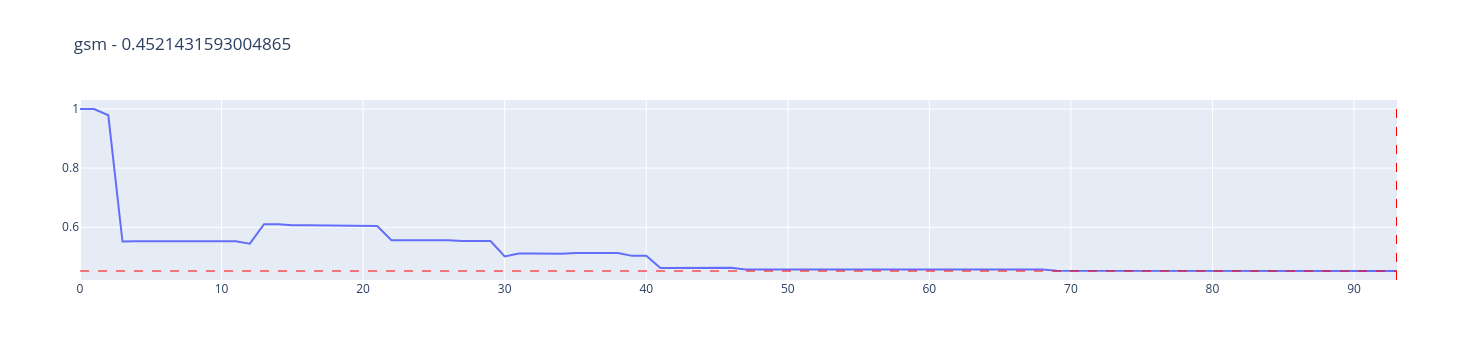

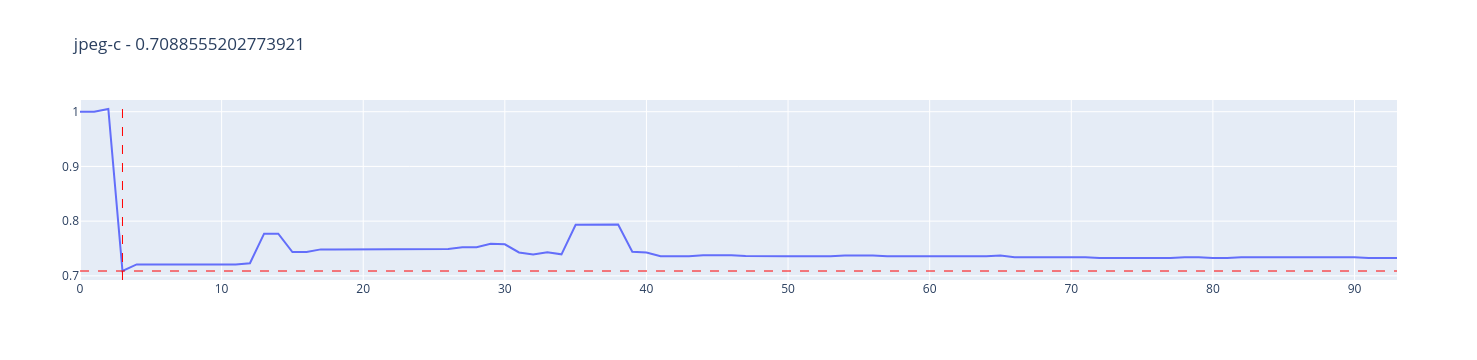

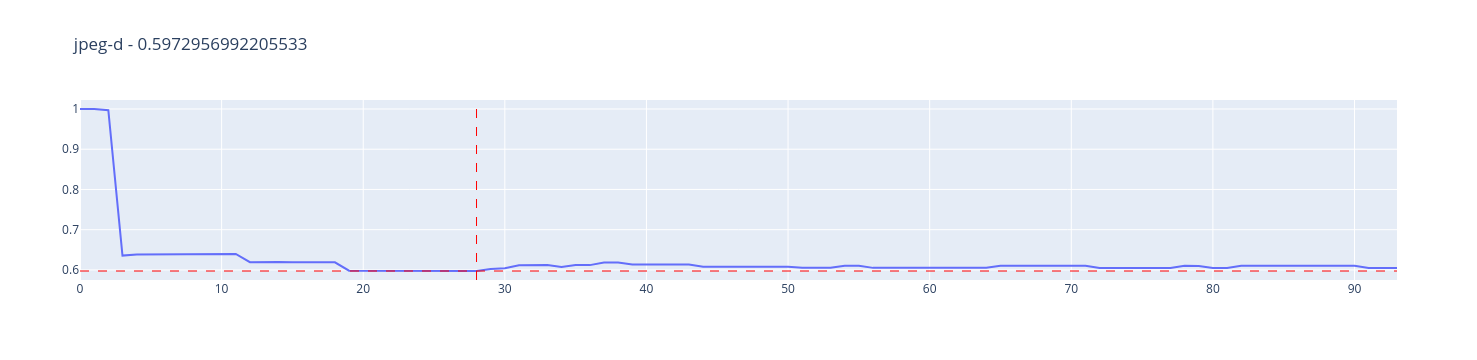

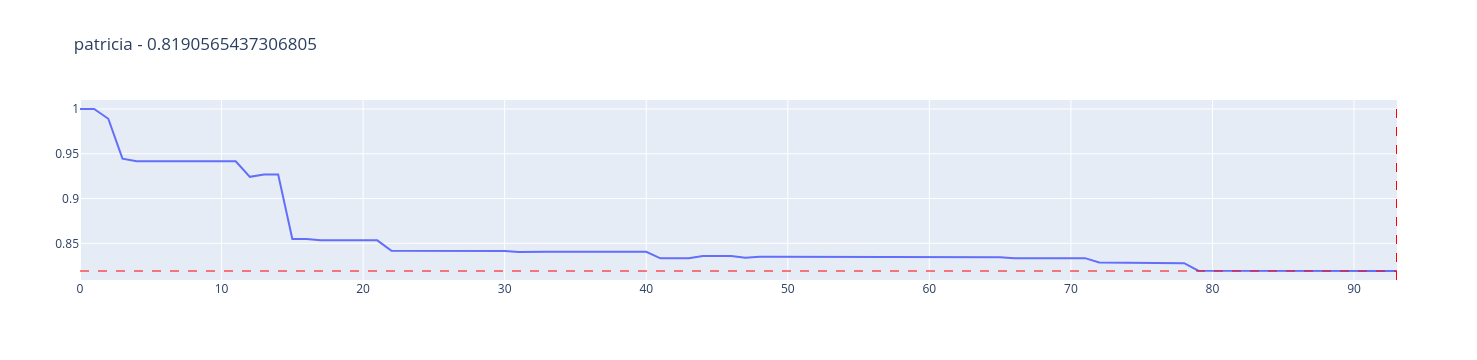

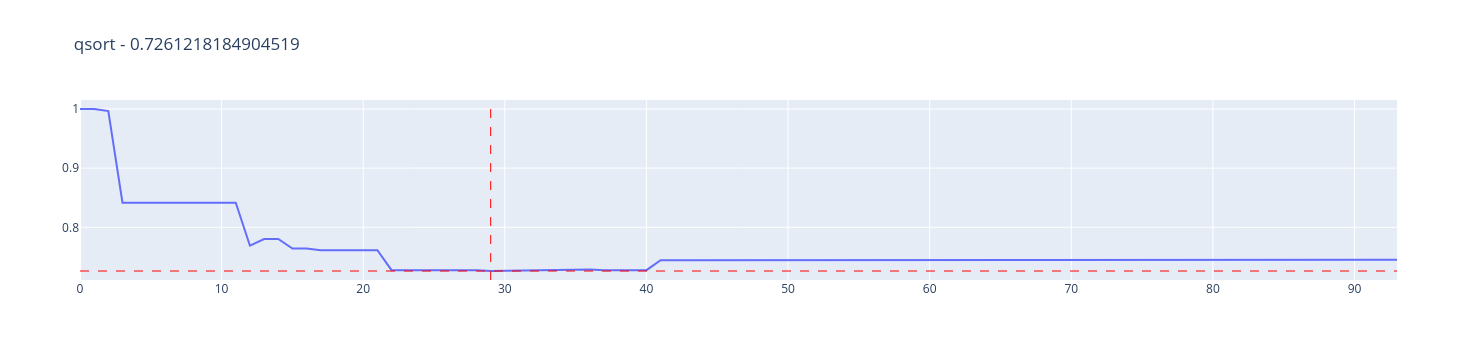

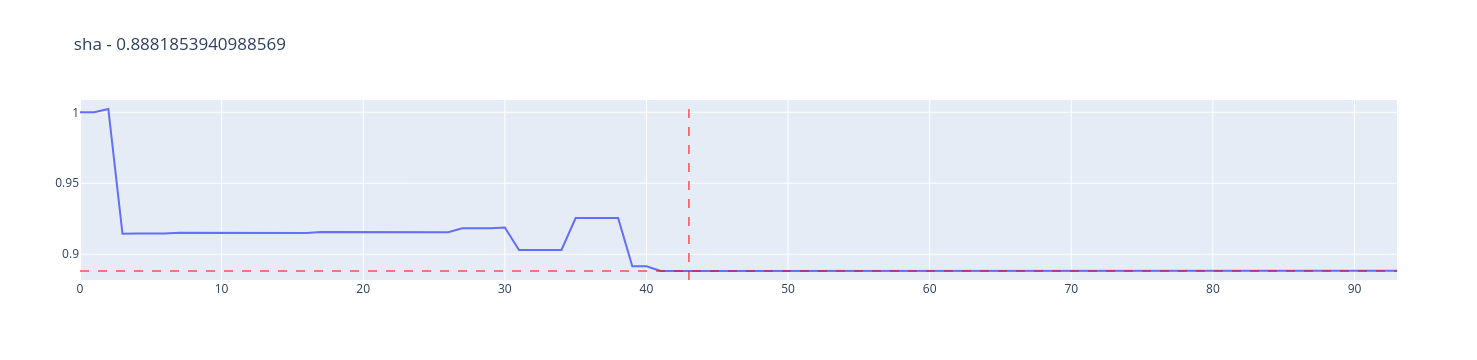

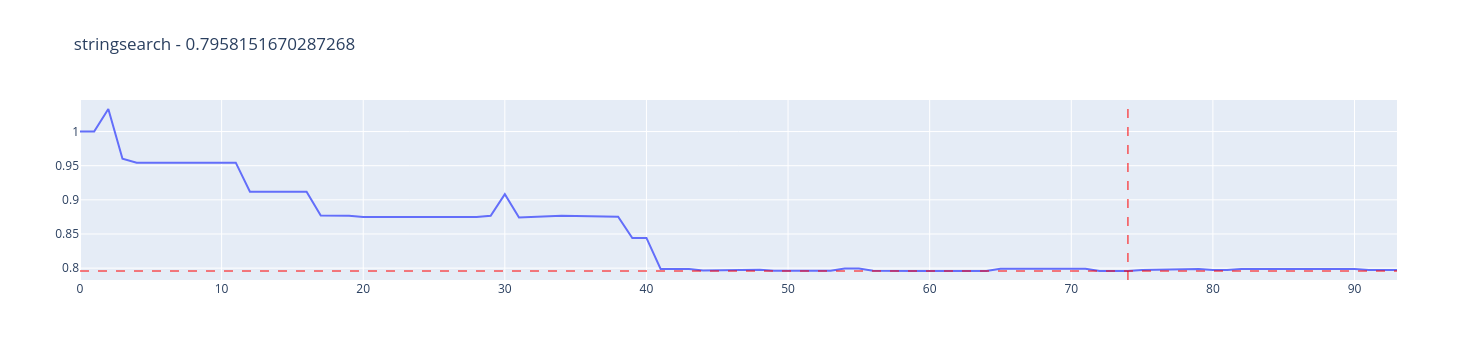

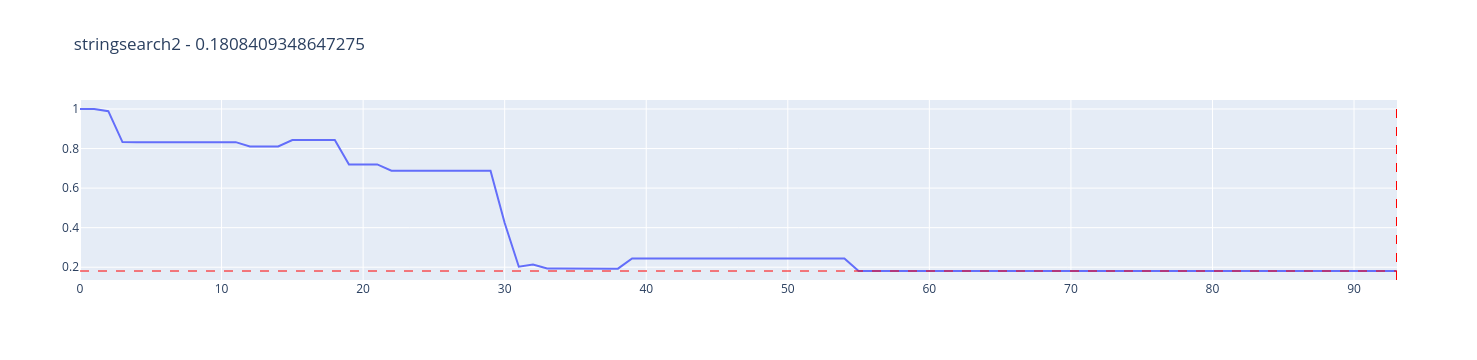

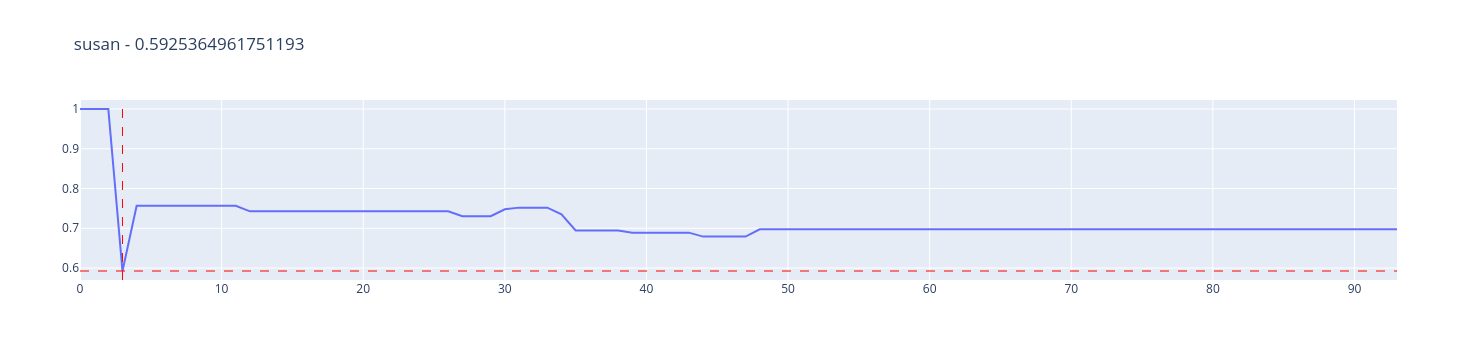

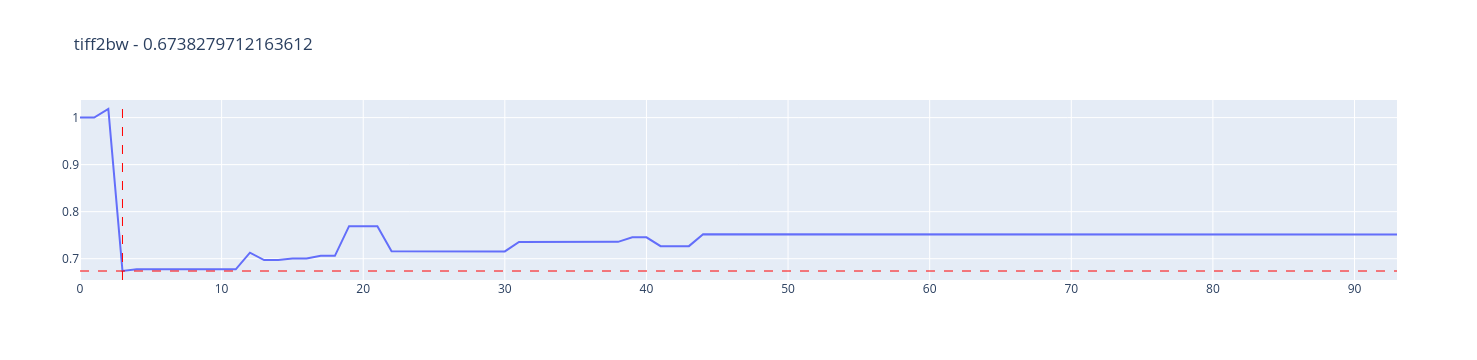

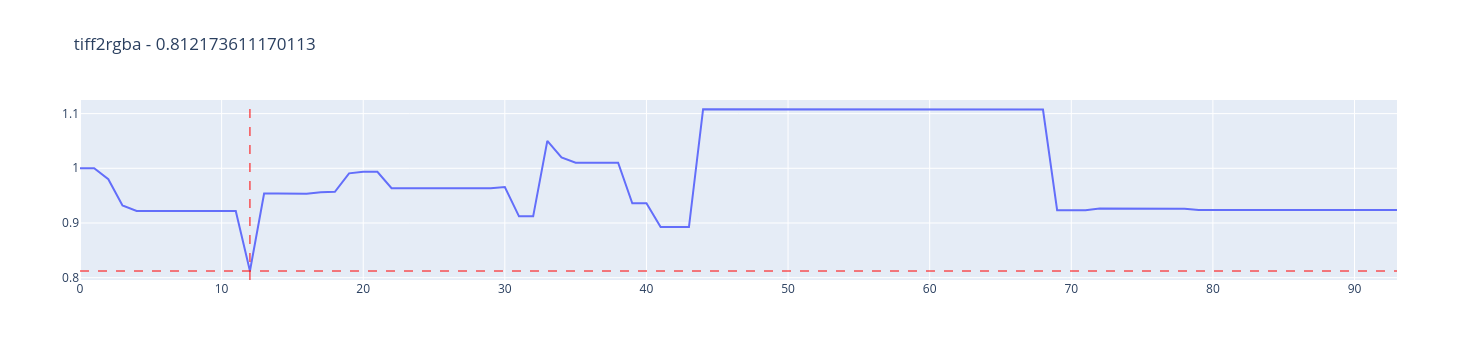

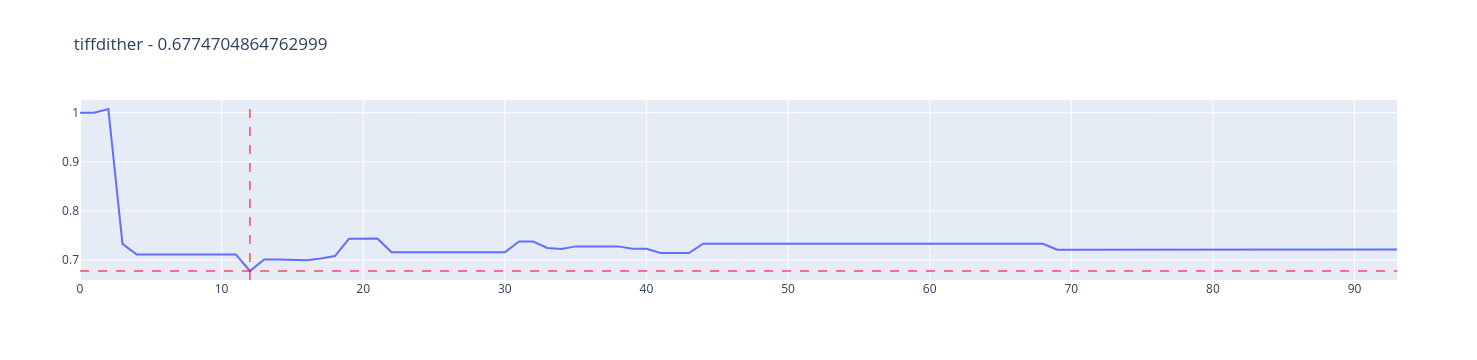

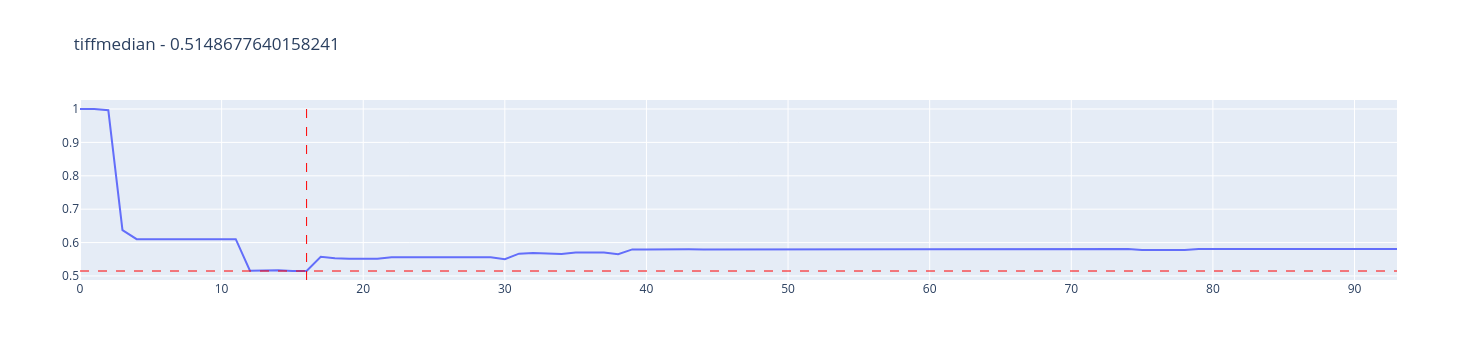

In [18]:
import plotly.graph_objects as go

agmins = []

for name, data in results.items():
    fig = go.Figure()
    if len(data) > 0:
        np_data = np.array(data)
        agmins.append(len(np_data) - np.argmin(np_data[::-1]) - 1)
        fig.add_trace(go.Scatter(y=np_data / np_data[0],
                    mode='lines',
                    # mode='lines+markers',
                    name=name))

        fig.add_hline(y=np.min(np_data / np_data[0]), line_width=1, line_dash="dash", line_color="red")
        fig.add_vline(x=agmins[-1], line_width=1, line_dash="dash", line_color="red")
    
        # for i in range(len(O2_SEQ)):
        #     if O2_SEQ[i] == "-simplifycfg":
        #         fig.add_vline(x=i + 1, line_width=0.5, line_dash="dash")
        # for el in agmins_prev:
        #     fig.add_vline(x=el, line_width=0.5, line_dash="dash")
    
        
        fig.update_layout(
            # width=1750, height=1000
            # width=1750, height=1500
            title=f"{name} - {np_data.min()/ np_data[0]}",
        )
    fig.show()

In [33]:
actions = []
prev = 0
for i in sorted(set(agmins)):
    actions.append(o2_seq[prev:i])
    prev = i

In [34]:
sorted(set(agmins))

[3, 15, 21, 34, 35, 39, 47, 51, 64, 77, 95, 96]

In [37]:
# o3_seq

In [39]:
[' '.join(a) for a in actions]

['-ee-instrument -simplifycfg -sroa',
 '-early-cse -lower-expect -forceattrs -inferattrs -callsite-splitting -ipsccp -called-value-propagation -attributor -globalopt -mem2reg -deadargelim -instcombine',
 '-simplifycfg -prune-eh -inline -functionattrs -argpromotion -sroa',
 '-early-cse-memssa -speculative-execution -jump-threading -correlated-propagation -simplifycfg -aggressive-instcombine -instcombine -libcalls-shrinkwrap -pgo-memop-opt -tailcallelim -simplifycfg -reassociate -loop-simplify',
 '-lcssa',
 '-loop-rotate -licm -loop-unswitch -simplifycfg',
 '-instcombine -loop-simplify -lcssa -indvars -loop-idiom -loop-deletion -loop-unroll -mldst-motion',
 '-gvn -memcpyopt -sccp -bdce',
 '-instcombine -jump-threading -correlated-propagation -dse -loop-simplify -lcssa -licm -adce -simplifycfg -instcombine -barrier -elim-avail-extern -rpo-functionattrs',
 '-globalopt -globaldce -float2int -lower-constant-intrinsics -loop-simplify -lcssa -loop-rotate -loop-distribute -loop-vectorize -loop-

In [36]:
actions

[['-ee-instrument', '-simplifycfg', '-sroa'],
 ['-early-cse',
  '-lower-expect',
  '-forceattrs',
  '-inferattrs',
  '-callsite-splitting',
  '-ipsccp',
  '-called-value-propagation',
  '-attributor',
  '-globalopt',
  '-mem2reg',
  '-deadargelim',
  '-instcombine'],
 ['-simplifycfg',
  '-prune-eh',
  '-inline',
  '-functionattrs',
  '-argpromotion',
  '-sroa'],
 ['-early-cse-memssa',
  '-speculative-execution',
  '-jump-threading',
  '-correlated-propagation',
  '-simplifycfg',
  '-aggressive-instcombine',
  '-instcombine',
  '-libcalls-shrinkwrap',
  '-pgo-memop-opt',
  '-tailcallelim',
  '-simplifycfg',
  '-reassociate',
  '-loop-simplify'],
 ['-lcssa'],
 ['-loop-rotate', '-licm', '-loop-unswitch', '-simplifycfg'],
 ['-instcombine',
  '-loop-simplify',
  '-lcssa',
  '-indvars',
  '-loop-idiom',
  '-loop-deletion',
  '-loop-unroll',
  '-mldst-motion'],
 ['-gvn', '-memcpyopt', '-sccp', '-bdce'],
 ['-instcombine',
  '-jump-threading',
  '-correlated-propagation',
  '-dse',
  '-loop-sim

In [38]:
len(actions)

12